# Investigating Transfer Learning from German to U.S. Traffic Signs

This notebook demonstrates how to load an ImageNet-pretrained ResNet50 model and investigate transfer learning by pretraining the model on a traffic-sign dataset from one country and fine-tuning it to predict traffic signs from another country, using the German-to-U.S. scenario as a case study.

## Datasets
German Traffic Signs (German Traffic Sign Recognition Benchmark GTSRB):
J. Stallkamp, M. Schlipsing, J. Salmen, and C. Igel. The German Traffic Sign Recognition Benchmark: A multi-class classification competition. In Proceedings of the IEEE International Joint Conference on Neural Networks, pages 1453–1460. 2011.

U.S. Traffic Signs (LISA Traffic Sign Dataset):
Andreas Møgelmose, Mohan M. Trivedi, and Thomas B. Moeslund, “Vision based Traffic Sign Detection and Analysis for Intelligent Driver Assistance Systems: Perspectives and Survey,” IEEE Transactions on Intelligent Transportation Systems, 2012.

In [ ]:
!pip install requests pandas numpy matplotlib pillow torch torchvision

In [ ]:
from lisa import LISA # local file

import os
import requests
import zipfile
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torchvision.models import ResNet50_Weights, resnet50
from torchvision.datasets import GTSRB
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

Set random seed for reproducibility and define the device (CPU or GPU)


In [ ]:
# for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Load a pre-trained ResNet-50 model with ImageNet weights and save the model weights

In [ ]:
base_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
base_model.eval()

# save the model weights
torch.save(base_model.state_dict(), "model/resnet50_imagenet_weights.pth")
print(base_model)

Load and preprocess the GTSRB dataset with data augmentation and normalization

In [ ]:
# 43 GTSRB class labels (https://benchmark.ini.rub.de/gtsrb_news.html)
class_names_GTSRB = [
    "speed limit (20km/h)", "speed limit (30km/h)", "speed limit (50km/h)", "speed limit (60km/h)",
    "speed limit (70km/h)", "speed limit (80km/h)", "end of speed limit (80km/h)", "speed limit (100km/h)",
    "speed limit (120km/h)", "no passing", "no passing for vehicles over 3.5 metric tons",
    "right-of-way at the next intersection", "priority road", "yield", "stop", "no vehicles",
    "vehicles over 3.5 metric tons prohibited", "no entry", "general caution", "dangerous curve to the left",
    "dangerous curve to the right", "double curve", "bumpy road", "slippery road", "road narrows on the right",
    "road work", "traffic signals", "pedestrians", "children crossing", "bicycles crossing",
    "beware of ice/snow", "wild animals crossing", "end of all speed and passing limits",
    "turn right ahead", "turn left ahead", "ahead only", "go straight or right", "go straight or left",
    "keep right", "keep left", "roundabout mandatory", "end of no passing",
    "end of no passing by vehicles over 3.5 metric tons"
]

data_dir = "./data/GTSRB"

# mean/std ImageNet statistics (https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# training transform (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# validation / test transform (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# load full train / test from disk
full_train = GTSRB(
    root=data_dir,
    split="train",
    transform=train_transform,
    download=False
)
test_ds_GTSRB = GTSRB(
    root=data_dir,
    split="test",
    transform=val_test_transform,
    download=False
)

# 80/20 train/val split (on full_train)
train_size = int(0.8 * len(full_train))
val_size   = len(full_train) - train_size
train_ds_GTSRB, val_ds_GTSRB = random_split(
    full_train,
    [train_size, val_size]
)

# DataLoaders
batch_size = 64
train_loader_GTSRB = DataLoader(
    train_ds_GTSRB,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)
val_loader_GTSRB = DataLoader(
    val_ds_GTSRB,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)
test_loader_GTSRB = DataLoader(
    test_ds_GTSRB,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

print("GTSRB Dataset splits:")
print(f"  Training:   {len(train_ds_GTSRB)} samples")
print(f"  Validation: {len(val_ds_GTSRB)} samples")
print(f"  Test:       {len(test_ds_GTSRB)} samples")

Load and preprocess the LISA dataset with data augmentation and normalization

In [ ]:
# mean/std the author reports (https://github.com/AminJun/lisa)
mean = [0.4563, 0.4076, 0.3895]
std  = [0.2298, 0.2144, 0.2259]

data_dir = "./data/LISA"

# specify transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# load the datasets (same pattern as GTSRB)
full_train_LISA = LISA(root=data_dir, 
                       train=True,
                      transform=train_transform, 
                       download=False)
test_ds_LISA    = LISA(root=data_dir, 
                       train=False,
                      transform=val_test_transform, 
                       download=False)

# split training set into train + validation (80/20 split like GTSRB)
train_size = int(0.8 * len(full_train_LISA))
val_size   = len(full_train_LISA) - train_size
train_ds_LISA, val_ds_LISA = random_split(
    full_train_LISA, [train_size, val_size]
)

# create DataLoaders
batch_size = 64
train_loader_LISA = DataLoader(
    train_ds_LISA, 
    batch_size=batch_size,                  
    shuffle=True,  
    num_workers=4
)
val_loader_LISA   = DataLoader(val_ds_LISA,   
                               batch_size=batch_size,
                               shuffle=False, 
                               num_workers=4
)
test_loader_LISA  = DataLoader(test_ds_LISA,  
                               batch_size=batch_size,
                               shuffle=False, 
                               num_workers=4
)

class_names_LISA = full_train_LISA.classes
num_classes_LISA = len(class_names_LISA)
print(f"LISA Number of Classes:")
print(num_classes_LISA)
print(f"LISA Classes:")
print(class_names_LISA)

print(f"LISA Dataset splits:")
print(f"Training: {len(train_ds_LISA)} samples")
print(f"Validation: {len(val_ds_LISA)} samples")
print(f"Test: {len(test_ds_LISA)} samples")

In [ ]:
# hyper-params & device
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-4
num_epochs    = 10

num_classes_GTSRB = len(class_names_GTSRB)
print(num_classes_GTSRB)

In [ ]:
# number of classes in GTSRB
num_classes_GTSRB = len(class_names_GTSRB)

# model init
model_GTSRB = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model_GTSRB.fc = nn.Linear(model_GTSRB.fc.in_features, num_classes_GTSRB)
model_GTSRB = model_GTSRB.to(device)

# loss, optimizer, best-model tracking
criterion_GTSRB      = nn.CrossEntropyLoss()
optimizer_GTSRB      = optim.Adam(model_GTSRB.parameters(), lr=learning_rate)
best_acc_GTSRB       = 0.0
best_epoch_GTSRB     = 0
best_wts_GTSRB       = copy.deepcopy(model_GTSRB.state_dict())

# training loop
for epoch in range(1, num_epochs+1):
    model_GTSRB.train()
    running_loss = 0.0
    # train on train_loader 
    for imgs, labels in train_loader_GTSRB:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_GTSRB.zero_grad()
        out = model_GTSRB(imgs)
        loss = criterion_GTSRB(out, labels)
        loss.backward()
        optimizer_GTSRB.step()
        running_loss += loss.item() * imgs.size(0)
    train_loss = running_loss / len(train_loader_GTSRB.dataset)

    # validate on val_loader
    model_GTSRB.eval()
    correct = 0
    with torch.no_grad():
        for imgs, labels in val_loader_GTSRB:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model_GTSRB(imgs).argmax(dim=1)
            correct += (preds == labels).sum().item()
    val_acc = correct / len(val_loader_GTSRB.dataset)

    # keep best
    if val_acc > best_acc_GTSRB:
        best_acc_GTSRB   = val_acc
        best_epoch_GTSRB = epoch
        best_wts_GTSRB   = copy.deepcopy(model_GTSRB.state_dict())

    print(f"[GTSRB] Epoch {epoch:2d}/{num_epochs} — "
          f"Train Loss: {train_loss:.4f} — Val Acc: {val_acc:.4f}")

# final test‐set evaluation
model_GTSRB.load_state_dict(best_wts_GTSRB)
model_GTSRB.eval()
test_correct = 0
with torch.no_grad():
    for imgs, labels in test_loader_GTSRB:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model_GTSRB(imgs).argmax(dim=1)
        test_correct += (preds == labels).sum().item()
test_acc = test_correct / len(test_loader_GTSRB.dataset)

print(f"\n[GTSRB] Best Val Epoch: {best_epoch_GTSRB} — Val Acc: {best_acc_GTSRB:.4f}")
print(f"[GTSRB] Final Test Acc: {test_acc:.4f}")

# save best weights
torch.save(best_wts_GTSRB, "./model/resnet50_gtsrb_best.pth")
print("[GTSRB] Saved best weights to ./model/resnet50_gtsrb_best.pth")

In [21]:
# number of classes in LISA
num_classes_LISA = len(class_names_LISA)

# model init
model_LISA = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model_LISA.fc = nn.Linear(model_LISA.fc.in_features, num_classes_LISA)
model_LISA = model_LISA.to(device)

# loss, optimizer, best-model tracking
criterion_LISA      = nn.CrossEntropyLoss()
optimizer_LISA      = optim.Adam(model_LISA.parameters(), lr=learning_rate)
best_acc_LISA       = 0.0
best_epoch_LISA     = 0
best_wts_LISA       = copy.deepcopy(model_LISA.state_dict())

# training loop
for epoch in range(1, num_epochs+1):
    model_LISA.train()
    running_loss = 0.0
    # train on train_loader 
    for imgs, labels in train_loader_LISA:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_LISA.zero_grad()
        out = model_LISA(imgs)
        loss = criterion_LISA(out, labels)
        loss.backward()
        optimizer_LISA.step()
        running_loss += loss.item() * imgs.size(0)
    train_loss = running_loss / len(train_loader_LISA.dataset)

    # validate on val_loader
    model_LISA.eval()
    correct = 0
    with torch.no_grad():
        for imgs, labels in val_loader_LISA:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model_LISA(imgs).argmax(dim=1)
            correct += (preds == labels).sum().item()
    val_acc = correct / len(val_loader_LISA.dataset)

    # keep best
    if val_acc > best_acc_LISA:
        best_acc_LISA   = val_acc
        best_epoch_LISA = epoch
        best_wts_LISA   = copy.deepcopy(model_LISA.state_dict())

    print(f"[LISA] Epoch {epoch:2d}/{num_epochs} — "
          f"Train Loss: {train_loss:.4f} — Val Acc: {val_acc:.4f}")

# final test‐set evaluation
model_LISA.load_state_dict(best_wts_LISA)
model_LISA.eval()
test_correct = 0
with torch.no_grad():
    for imgs, labels in test_loader_LISA:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model_LISA(imgs).argmax(dim=1)
        test_correct += (preds == labels).sum().item()
test_acc = test_correct / len(test_loader_LISA.dataset)

print(f"\n[LISA] Best Val Epoch: {best_epoch_LISA} — Val Acc: {best_acc_LISA:.4f}")
print(f"[LISA] Final Test Acc: {test_acc:.4f}")

# save best weights
torch.save(best_wts_LISA, "./model/resnet50_lisa_best.pth")
print("[LISA] Saved best weights to ./model/resnet50_lisa_best.pth")

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/bwhpc/common/jupyter/ai/2025-02-20/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/opt/bwhpc/common/jupyter/ai/2025-02-20/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/bwhpc/common/jupyter/ai/2025-02-20/lib/python3.11/site-packages/torch/utils/data/dataset.py", line 420, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/bwhpc/common/jupyter/ai/2025-02-20/lib/python3.11/site-packages/torch/utils/data/dataset.py", line 420, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "/pfs/data6/home/ds/ds_ds/ds_wi22230/TrafficSign_TransferLearning/lisa.py", line 65, in __getitem__
    img = img if self.transform is None else self.transform(img)
                                             ^^^^^^^^^^^^^^^^^^^
  File "/opt/bwhpc/common/jupyter/ai/2025-02-20/lib/python3.11/site-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
          ^^^^^^
  File "/opt/bwhpc/common/jupyter/ai/2025-02-20/lib/python3.11/site-packages/torchvision/transforms/transforms.py", line 137, in __call__
    return F.to_tensor(pic)
           ^^^^^^^^^^^^^^^^
  File "/opt/bwhpc/common/jupyter/ai/2025-02-20/lib/python3.11/site-packages/torchvision/transforms/functional.py", line 142, in to_tensor
    raise TypeError(f"pic should be PIL Image or ndarray. Got {type(pic)}")
TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>


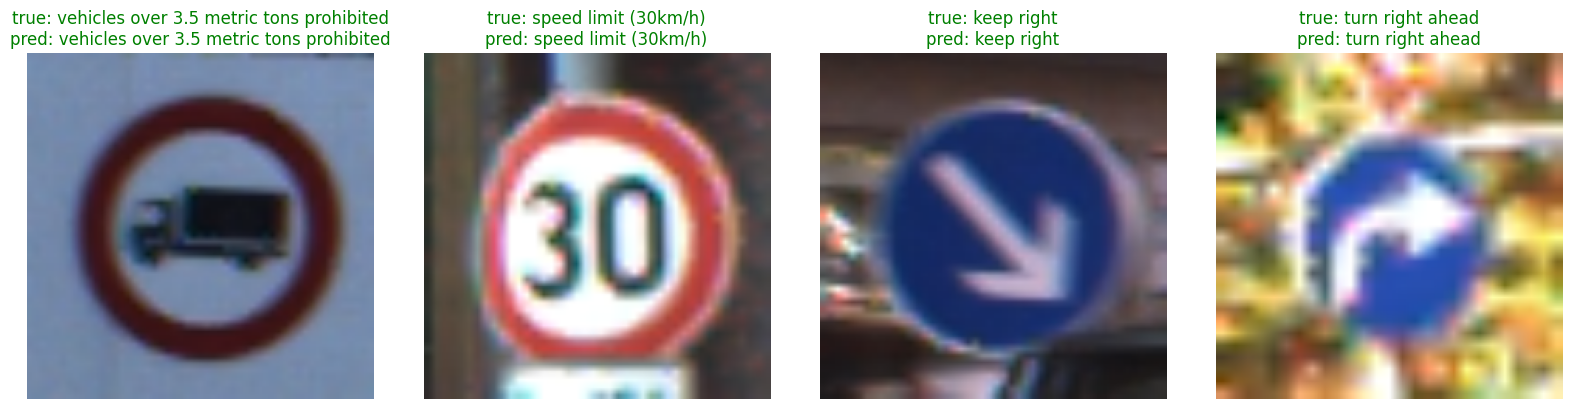

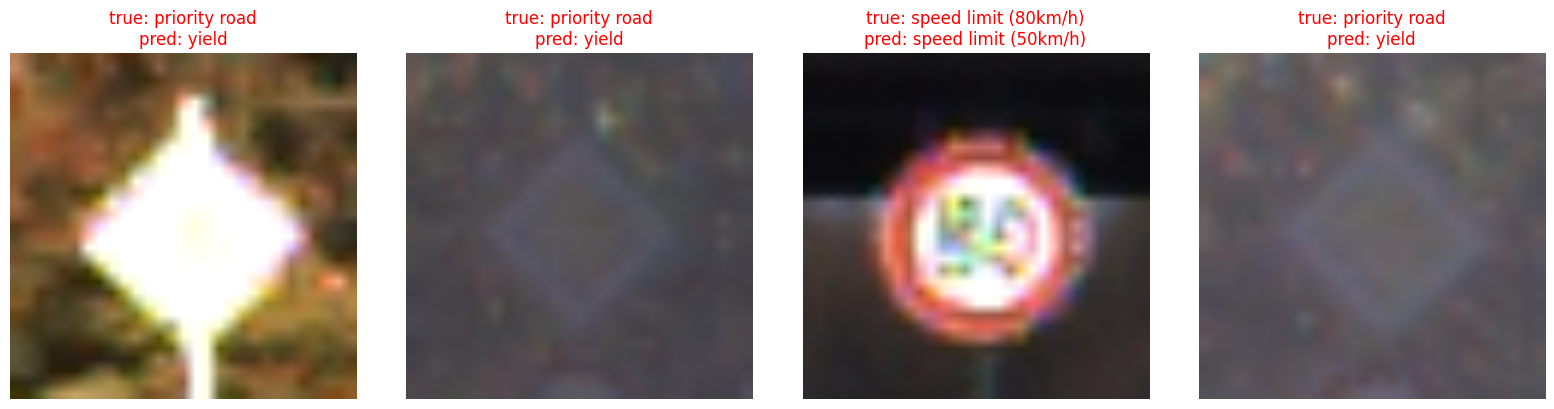

In [24]:
# load the fine-tuned GTSRB model and define architecture
num_classes = 43
GTSRB_model = resnet50(weights=None)
GTSRB_model.fc = torch.nn.Linear(GTSRB_model.fc.in_features, num_classes)
GTSRB_model.load_state_dict(torch.load("./model/resnet50_gtsrb_best.pth", map_location=device))
GTSRB_model = GTSRB_model.to(device)
GTSRB_model.eval()

def find_confident_wrong_predictions(model, test_loader, device, target_incorrect=4):
    incorrect_with_confidence = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            
            for i in range(len(images)):
                if labels[i] != preds[i]:  # Incorrect prediction
                    img = images[i].cpu().permute(1, 2, 0).numpy()
                    label = labels[i].item()
                    pred = preds[i].item()
                    confidence = probs[i][pred].item()  # Confidence in wrong prediction
                    
                    incorrect_with_confidence.append((img, label, pred, confidence))
    
    # Sort by confidence (most confident wrong predictions first)
    incorrect_with_confidence.sort(key=lambda x: x[3], reverse=True)
    
    # Return top N most confident incorrect predictions
    incorrect = [(img, label, pred) for img, label, pred, conf in incorrect_with_confidence[:target_incorrect]]
    
    return incorrect

def find_correct_predictions(model, test_loader, device, target_correct=4):
    correct = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images).argmax(dim=1)
            
            for i in range(len(images)):
                if labels[i] == preds[i] and len(correct) < target_correct:
                    img = images[i].cpu().permute(1, 2, 0).numpy()
                    label = labels[i].item()
                    pred = preds[i].item()
                    correct.append((img, label, pred))
                
                if len(correct) >= target_correct:
                    return correct
    
    return correct

# get the most confident wrong predictions
incorrect = find_confident_wrong_predictions(GTSRB_model, test_loader_GTSRB, device)
# get some correct predictions for comparison
correct = find_correct_predictions(GTSRB_model, test_loader_GTSRB, device, target_correct=4)

# plot correct predictions
if correct:
    plt.figure(figsize=(16, 4))
    for idx, (img, label, pred) in enumerate(correct):
        plt.subplot(1, 4, idx + 1)
        plt.imshow(img)
        plt.title(f"true: {class_names[label]}\npred: {class_names[pred]}", color="green")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# plot incorrect predictions
if incorrect:
    plt.figure(figsize=(16, 4))
    for idx, (img, label, pred) in enumerate(incorrect):
        plt.subplot(1, 4, idx + 1)
        plt.imshow(img)
        plt.title(f"true: {class_names[label]}\npred: {class_names[pred]}", color="red")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [25]:
# load the fine-tuned LISA model and define architecture
num_classes_lisa = 49
LISA_model = resnet50(weights=None)
LISA_model.fc = torch.nn.Linear(LISA_model.fc.in_features, num_classes_lisa)
LISA_model.load_state_dict(torch.load("./model/resnet50_lisa_best.pth", map_location=device))
LISA_model = LISA_model.to(device)
LISA_model.eval()

def find_confident_wrong_predictions(model, test_loader, device, target_incorrect=4):
    incorrect_with_confidence = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            
            for i in range(len(images)):
                if labels[i] != preds[i]:  # Incorrect prediction
                    img = images[i].cpu().permute(1, 2, 0).numpy()
                    label = labels[i].item()
                    pred = preds[i].item()
                    confidence = probs[i][pred].item()  # Confidence in wrong prediction
                    
                    incorrect_with_confidence.append((img, label, pred, confidence))
    
    # Sort by confidence (most confident wrong predictions first)
    incorrect_with_confidence.sort(key=lambda x: x[3], reverse=True)
    
    # Return top N most confident incorrect predictions
    incorrect = [(img, label, pred) for img, label, pred, conf in incorrect_with_confidence[:target_incorrect]]
    
    return incorrect

def find_correct_predictions(model, test_loader, device, target_correct=4):
    correct = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images).argmax(dim=1)
            
            for i in range(len(images)):
                if labels[i] == preds[i] and len(correct) < target_correct:
                    img = images[i].cpu().permute(1, 2, 0).numpy()
                    label = labels[i].item()
                    pred = preds[i].item()
                    correct.append((img, label, pred))
                
                if len(correct) >= target_correct:
                    return correct
    
    return correct

# Get the most confident wrong predictions for LISA
incorrect_lisa = find_confident_wrong_predictions(LISA_model, test_loader_LISA, device)
# Get some correct predictions for comparison
correct_lisa = find_correct_predictions(LISA_model, test_loader_LISA, device, target_correct=4)

# plot correct predictions for LISA
if correct_lisa:
    plt.figure(figsize=(16, 4))
    for idx, (img, label, pred) in enumerate(correct_lisa):
        plt.subplot(1, 4, idx + 1)
        plt.imshow(img)
        plt.title(f"Correct\ntrue: {lisa_class_names[label]}\npred: {lisa_class_names[pred]}", color="green")
        plt.axis("off")
    plt.suptitle("LISA Model - Correct Predictions")
    plt.tight_layout()
    plt.show()

# plot incorrect predictions for LISA
if incorrect_lisa:
    plt.figure(figsize=(16, 4))
    for idx, (img, label, pred) in enumerate(incorrect_lisa):
        plt.subplot(1, 4, idx + 1)
        plt.imshow(img)
        plt.title(f"Incorrect\ntrue: {lisa_class_names[label]}\npred: {lisa_class_names[pred]}", color="red")
        plt.axis("off")
    plt.suptitle("LISA Model - Most Confident Incorrect Predictions")
    plt.tight_layout()
    plt.show()

NameError: name 'test_loader_LISA' is not defined

In [9]:
# evaluate base model (imagenet-pretrained, random fc layer)
base_model = base_model.to(device)
base_model.eval()

correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader_GTSRB:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = base_model(imgs)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
base_acc = correct / total
print(f"base model (imagenet pretrained, random fc) accuracy on gtsrb: {base_acc:.4f}")

# evaluate fine-tuned model (imagenet-pretrained + gtsrb fine-tuned)
finetuned_model = resnet50(weights=None)
finetuned_model.fc = torch.nn.Linear(finetuned_model.fc.in_features, num_classes)
finetuned_model.load_state_dict(torch.load("./model/resnet50_gtsrb_best.pth"))
finetuned_model = finetuned_model.to(device)
finetuned_model.eval()

correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader_GTSRB:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = finetuned_model(imgs)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
finetuned_acc = correct / total
print(f"fine-tuned model accuracy on gtsrb: {finetuned_acc:.4f}")

base model (imagenet pretrained, random fc) accuracy on gtsrb: 0.0000
fine-tuned model accuracy on gtsrb: 0.9889
